# Digit recognizer 

![title](images/digits.png)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical

## Data exploration

### Load training and test datasets

In [13]:
# Kaggle provides the train and test sets
train_set = pd.read_csv("data/train.csv")
test_set = pd.read_csv("data/test.csv")

### Length and dimensionalities

In [14]:
print("Train set shape")
print(train_set.shape[0], " observations by ", train_set.shape[1], " attributes")
print("Test set shape")
print(test_set.shape[0], " observations by ", test_set.shape[1], " attributes")

Train set shape
42000  observations by  785  attributes
Test set shape
28000  observations by  784  attributes


### Split training set (training and validation sets)

In [15]:
# Store output variable in vector
y_train = train_set['label']
# Delete attribute label from training set
X_train=train_set.drop(['label'], axis=1)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.35, random_state=9)

### Labels distribution

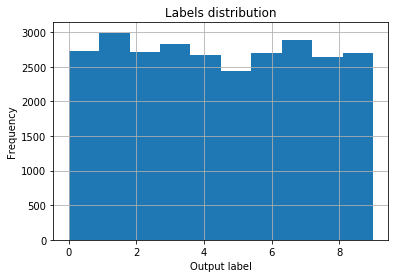

In [16]:
%matplotlib inline
# Labels frequency distribution 
y_train.hist()
plt.xlabel("Output label")
plt.ylabel("Frequency")
plt.title('Labels distribution')
plt.show()

### Visualize a single case

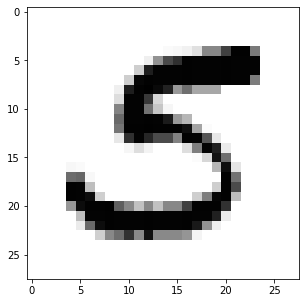

In [17]:
# Establish figure size
plt.rcParams['figure.figsize'] = (5.0, 5.0)
# Select only first observation and reshape to 28  * 28 matrix
sampleimage =  X_train.iloc[1].values.reshape(28, 28)
# Plot image in grey scale
im = plt.imshow(sampleimage, cmap='Greys')
plt.show()

## Logistic regression model

In [ ]:
# Instantiate the logisti regression model
model_log = LogisticRegression(multi_class="auto",random_state=9)
# Fit the LR model
model_log.fit(X_train, y_train)

c:\users\alfa2\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
# Validation set accuracy
model_log.score(X_val, y_val )

In [ ]:
# Generate test_set predictions
predictions = model_log.predict(test_set)

In [ ]:
# Format predictions (Kaggle submission)
predictions = pd.DataFrame({'ImageId': list(range(1, len(predictions)+1)),'label': predictions})
prediction = pd.DataFrame(predictions).to_csv('D:/kaggle_submissions/predictions.csv', index=False)

Kaggle public score : 0.89628

### Clustering for dimensionalty reduction

In [11]:
# Preprocess data with K means prior to trainning
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=90)),
    ("log_reg", LogisticRegression()),
])
# Fit a logistic regression model
pipeline.fit(X_train, y_train)

c:\users\alfa2\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\alfa2\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=90, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [36]:
# Validation set accuracy
pipeline.score(X_val, y_val)

0.9305442176870748

In [37]:
# Generate test_set predictions
k_means_preds = pipeline.predict(test_set)

In [38]:
# Format predictions (Kaggle submission)
k_means_preds = pd.DataFrame({'ImageId': list(range(1, len(k_means_preds)+1)),'label': k_means_preds})
k_means_pred = pd.DataFrame(k_means_preds).to_csv('D:/kaggle_submissions/k_means_preds.csv', index=False)

Kaggle public score : 0.92757

In [43]:
# Basic Convolutional network

In [22]:
###  Sequential model to build the model layer by layer
model = Sequential()
# Conv layer with 32 nodes with a filter matrix of 5 x 5
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Valid', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Valid', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

# Connection between convolution and dense layers
model.add(Flatten())
model.add(Dense(519, activation="relu"))
model.add(Dropout(0.5))
# 0 to 9 possible outcomes
model.add(Dense(10, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=["accuracy"])

annealer = ReduceLROnPlateau(monitor='val_acc', patience=1, verbose=2, factor=0.5, min_lr=0.0000001) #patience=2

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)  


In [19]:
# Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_train / 255.0

#Reshape train, val and test valuest o shape 28 x 28 greyscale
X_train = X_train.values.reshape(-1,28,28,1)
X_val = X_val.values.reshape(-1,28,28,1)
X_test = test_set.values.reshape(-1,28,28,1)

# One-hot encoding output variavle
y_train = to_categorical(y_train, num_classes = 10)
y_val = to_categorical(y_val, num_classes = 10)

In [23]:
epochs = 60
batch_size = 40
validation_steps = 10000

# initialize Model, Annealer and Datagen
#model, annealer, datagen = init_model()

# Start training
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = datagen.flow(X_val, y_val, batch_size=batch_size)

history = model.fit_generator(train_generator,
                    steps_per_epoch=X_train.shape[0]//batch_size,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps//batch_size,
                    callbacks=[annealer])

score = model.evaluate(X_val, y_val)
print('Validation accuracy: ', score[1])

Epoch 1/60
682/682 [==============================] - 24s 35ms/step - loss: 0.4119 - accuracy: 0.8658 - val_loss: 0.1341 - val_accuracy: 0.9721
Epoch 2/60
  4/682 [..............................] - ETA: 28s - loss: 0.1391 - accuracy: 0.9500

c:\users\alfa2\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


682/682 [==============================] - 23s 34ms/step - loss: 0.1183 - accuracy: 0.9650 - val_loss: 0.0515 - val_accuracy: 0.9832
Epoch 3/60
682/682 [==============================] - 23s 34ms/step - loss: 0.0846 - accuracy: 0.9751 - val_loss: 0.0705 - val_accuracy: 0.9800
Epoch 4/60
682/682 [==============================] - 23s 34ms/step - loss: 0.0735 - accuracy: 0.9782 - val_loss: 0.0130 - val_accuracy: 0.9844
Epoch 5/60
682/682 [==============================] - 23s 33ms/step - loss: 0.0645 - accuracy: 0.9813 - val_loss: 0.0209 - val_accuracy: 0.9851
Epoch 6/60
682/682 [==============================] - 23s 34ms/step - loss: 0.0542 - accuracy: 0.9832 - val_loss: 0.1326 - val_accuracy: 0.9854
Epoch 7/60
682/682 [==============================] - 23s 34ms/step - loss: 0.0538 - accuracy: 0.9841 - val_loss: 0.0026 - val_accuracy: 0.9867
Epoch 8/60
682/682 [==============================] - 23s 33ms/step - loss: 0.0530 - accuracy: 0.9843 - val_loss: 0.0371 - val_accuracy: 0.9878
Epo

In [24]:
cnn_preds = np.argmax(model.predict(X_test), axis=1)

In [25]:
# Format predictions (Kaggle submission)
cnn_preds = pd.DataFrame({'ImageId': list(range(1, len(cnn_preds)+1)),'label': cnn_preds})
cnn_preds = pd.DataFrame(cnn_preds).to_csv('D:/kaggle_submissions/cnn_preds.csv', index=False)

Kaggle public score : 0.99271